# Section 1

Analyses for Section 1 of the Manuscript.

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

from NegativeClassOptimization import utils, preprocessing, ml, config, datasets, visualisations

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [2]:
base_p = Path(config.DATA_BASE_PATH) / "Frozen_MiniAbsolut_ML_Transformer_Parameters_Absolut/transformer_parameterset_a764f9c7"
df = pd.read_csv(base_p / "closed_performance.tsv", sep='\t')
df.head()

,task,N_pos,N_neg,acc,recall,precision,f1
0,HIGH_VS_95LOW__3VRL__auto__0__1,5000,5000,0.9878,0.9934,0.982397,0.987868
1,HIGH_VS_LOOSER__3VRL__auto__0__1,5000,5000,0.7616,0.8708,0.714708,0.785070
2,ONE_VS_NINE__3VRL__auto__0__1,5000,5000,0.8614,0.9672,0.798283,0.874661
3,HIGH_VS_95LOW__3VRL__auto__0__42,5000,5000,0.9772,0.9816,0.973037,0.977300
4,HIGH_VS_LOOSER__3VRL__auto__0__42,5000,5000,0.6782,0.5584,0.734350,0.634401


In [3]:
records = []
for i, row in df.iterrows():
    task_str = row["task"]
    task = datasets.ClassificationTask.init_from_str(task_str)
    records.append({
        "task": task_str,
        "ag_pos": task.ag_pos,
        "ag_neg": task.ag_neg,
        "seed_id": task.seed_id,
        "split_id": task.split_id,
        "task_type": task.task_type.to_str(),
    })

df = pd.merge(df, pd.DataFrame(records), on="task")
df = df.loc[~((df["ag_pos"] == "HR2B") | (df["ag_neg"] == "HR2B"))].copy()

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
df["task_type_clean"] = df["task_type"].map(map_task_type_to_clean)
df["acc_closed"] = df["acc"].astype(float)

print(df.shape)
df.head(10)

(21, 14)


,task,N_pos,N_neg,acc,recall,precision,f1,ag_pos,ag_neg,seed_id,split_id,task_type,task_type_clean,acc_closed
0,HIGH_VS_95LOW__3VRL__auto__0__1,5000,5000,0.9878,0.9934,0.982397,0.987868,3VRL,auto,0,1,high_vs_95low,vs Non-binder,0.9878
1,HIGH_VS_LOOSER__3VRL__auto__0__1,5000,5000,0.7616,0.8708,0.714708,0.785070,3VRL,auto,0,1,high_vs_looser,vs Weak,0.7616
2,ONE_VS_NINE__3VRL__auto__0__1,5000,5000,0.8614,0.9672,0.798283,0.874661,3VRL,auto,0,1,1v9,vs 9,0.8614
3,HIGH_VS_95LOW__3VRL__auto__0__42,5000,5000,0.9772,0.9816,0.973037,0.977300,3VRL,auto,0,42,high_vs_95low,vs Non-binder,0.9772
4,HIGH_VS_LOOSER__3VRL__auto__0__42,5000,5000,0.6782,0.5584,0.734350,0.634401,3VRL,auto,0,42,high_vs_looser,vs Weak,0.6782
5,ONE_VS_NINE__3VRL__auto__0__42,5000,5000,0.8126,0.6904,0.913711,0.786512,3VRL,auto,0,42,1v9,vs 9,0.8126
6,ONE_VS_ONE__3VRL__1WEJ__0__0,5000,5000,0.9129,0.9350,0.895422,0.914783,3VRL,1WEJ,0,0,1v1,vs 1,0.9129
7,ONE_VS_ONE__3VRL__1WEJ__0__1,5000,5000,0.9215,0.9540,0.895775,0.923971,3VRL,1WEJ,0,1,1v1,vs 1,0.9215
8,ONE_VS_ONE__3VRL__1WEJ__0__42,5000,5000,0.6951,0.4638,0.863044,0.603356,3VRL,1WEJ,0,42,1v1,vs 1,0.6951
9,HIGH_VS_95LOW__1ADQ__auto__0__1,5000,5000,0.9351,0.9388,0.931904,0.935339,1ADQ,auto,0,1,high_vs_95low,vs Non-binder,0.9351


## vs Non-binder, vs Weak, vs 1, vs 9 performances

In [4]:
# Get order of antigens by high_vs_looser performance
ag_order = df.loc[df["task_type"] == "high_vs_looser"].groupby("ag_pos")["acc_closed"].mean().sort_values(ascending=False).index.to_list()

In [5]:
task_order = ["high_vs_95low", "high_vs_looser", "1v9", "1v1"]

map_task_type_to_clean = visualisations.PlotParams.map_task_type_to_clean.copy()
task_clean_order = [map_task_type_to_clean[x] for x in task_order]

/tmp/ipykernel_191768/3230654710.py:25: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.stripplot(


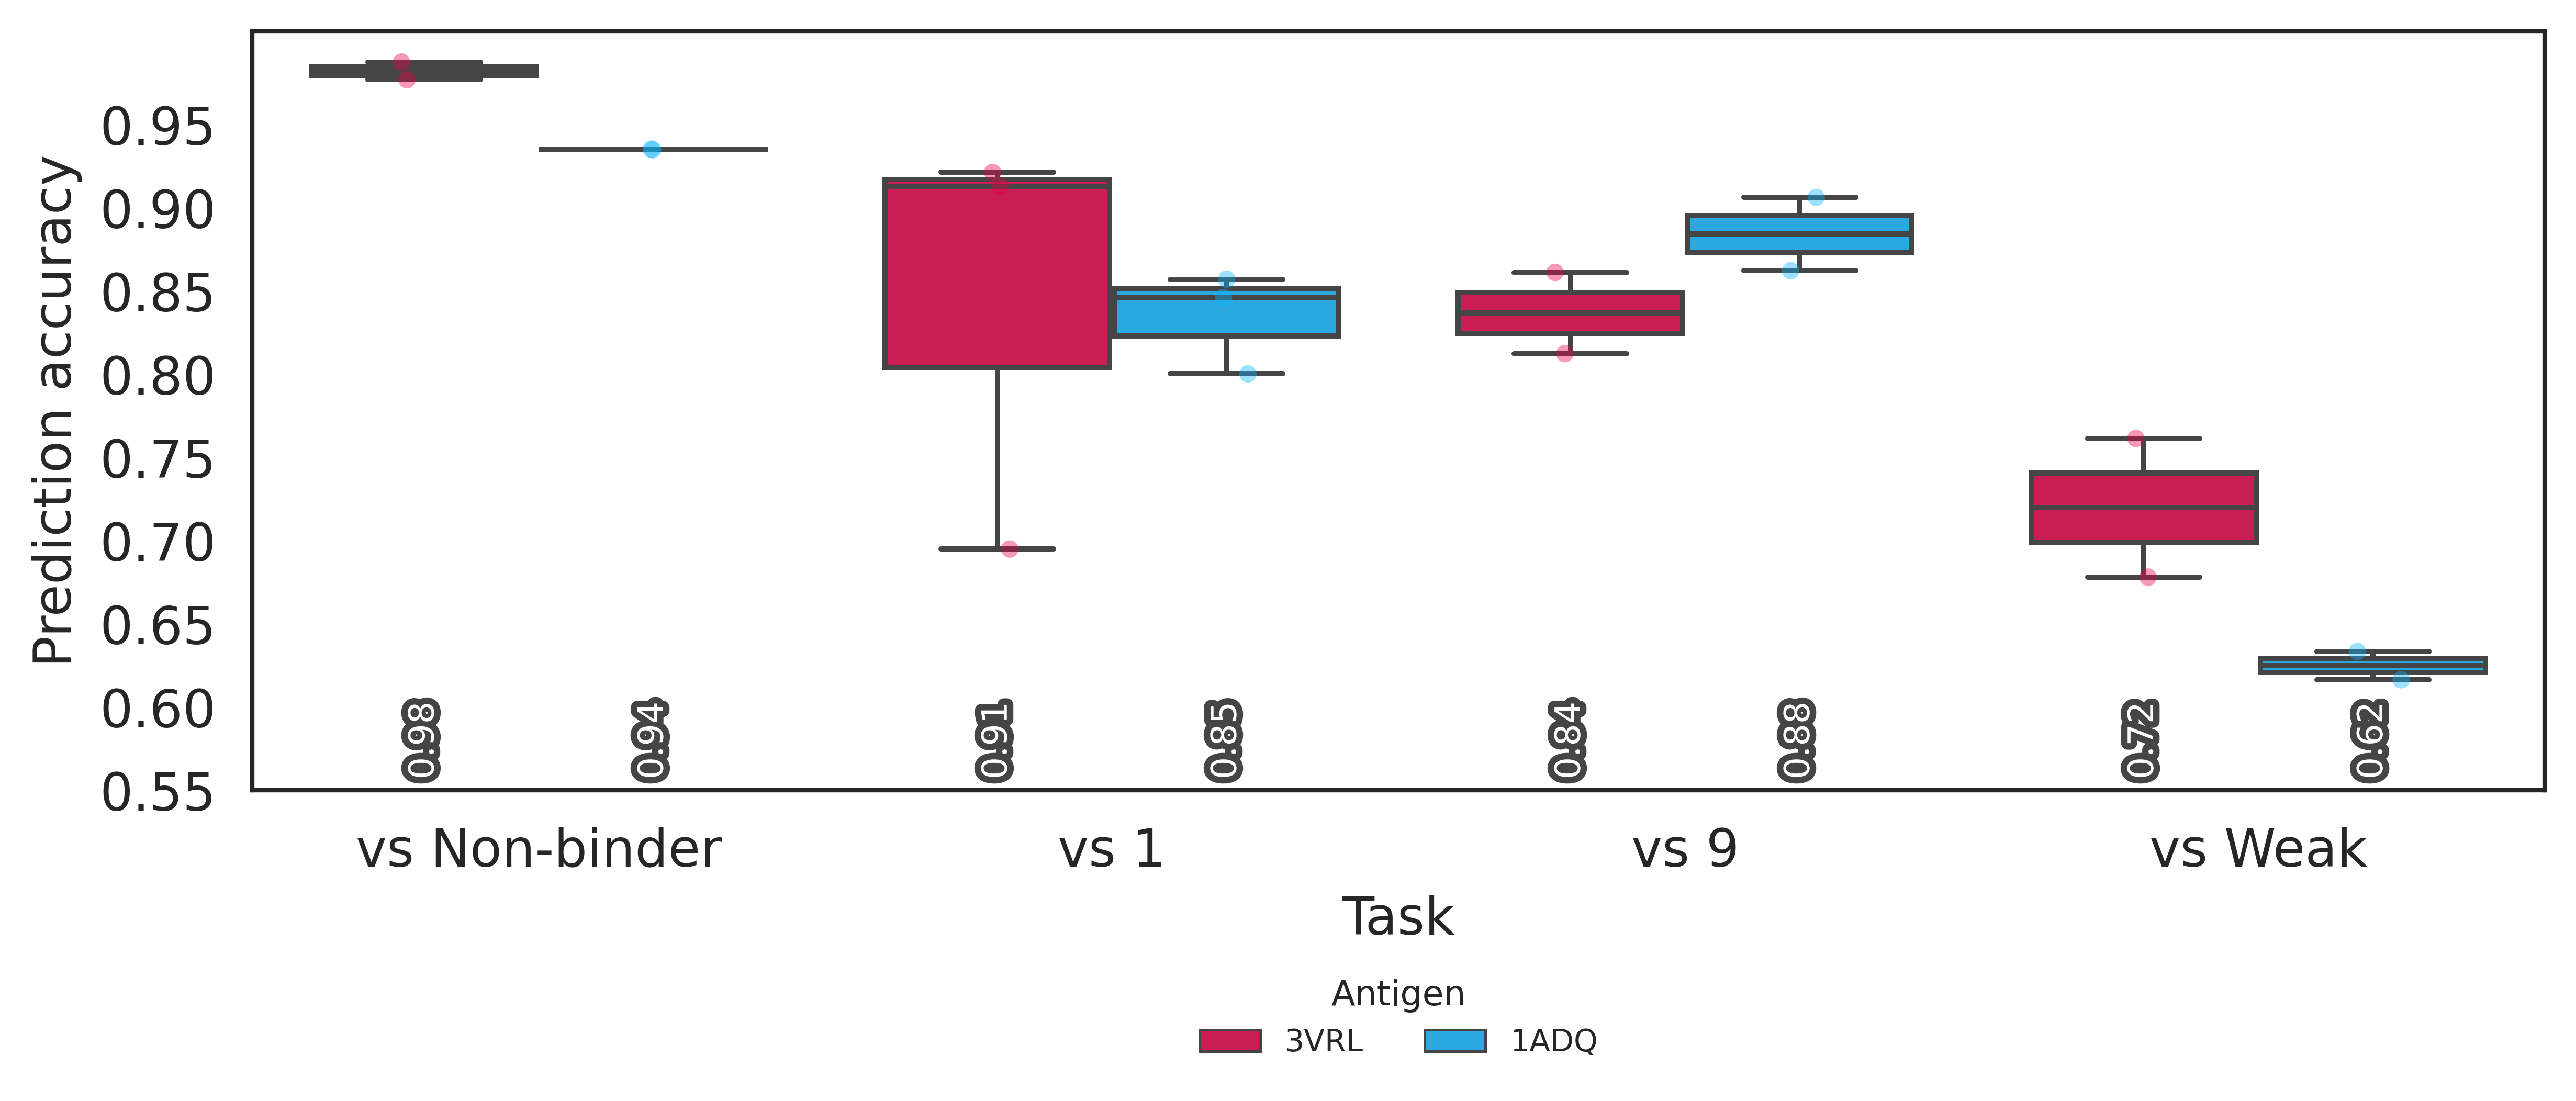

In [6]:
yticks = np.arange(0.55, 1.0, 0.05)
yaxis_title = "Prediction accuracy"
# ag_order = visualisations.PlotParams.order_antigens
task_order = visualisations.PlotParams.order_tasks
task_clean_order = visualisations.PlotParams.order_tasks_clean
cmap = visualisations.PlotParams.cmap_antigens

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)

# Transparent boxplot
sns.boxplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    boxprops=dict(alpha=1),
)
# Add data points on top of boxplot in low transparency
sns.stripplot(
    x="task_type_clean",
    y="acc_closed",
    hue="ag_pos",
    data=df,
    ax=ax,
    order=task_clean_order,
    hue_order=ag_order,
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

visualisations.add_median_labels(ax, y_level=0.58, fontsize=8)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Antigen",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)
ax.set_xlabel("Task", fontsize=12)
ax.set_ylabel(yaxis_title, fontsize=12)
ax.set_yticks(yticks)

fig.show()

In [7]:
df.groupby("task_type")["acc_closed"].agg(["median", "std"])

,median,std
task_type,,
1v1,0.84620,0.066108
1v9,0.86190,0.038361
high_vs_95low,0.95635,0.027593
high_vs_looser,0.65585,0.064880


/tmp/ipykernel_191768/2047051091.py:9: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  sns.stripplot(


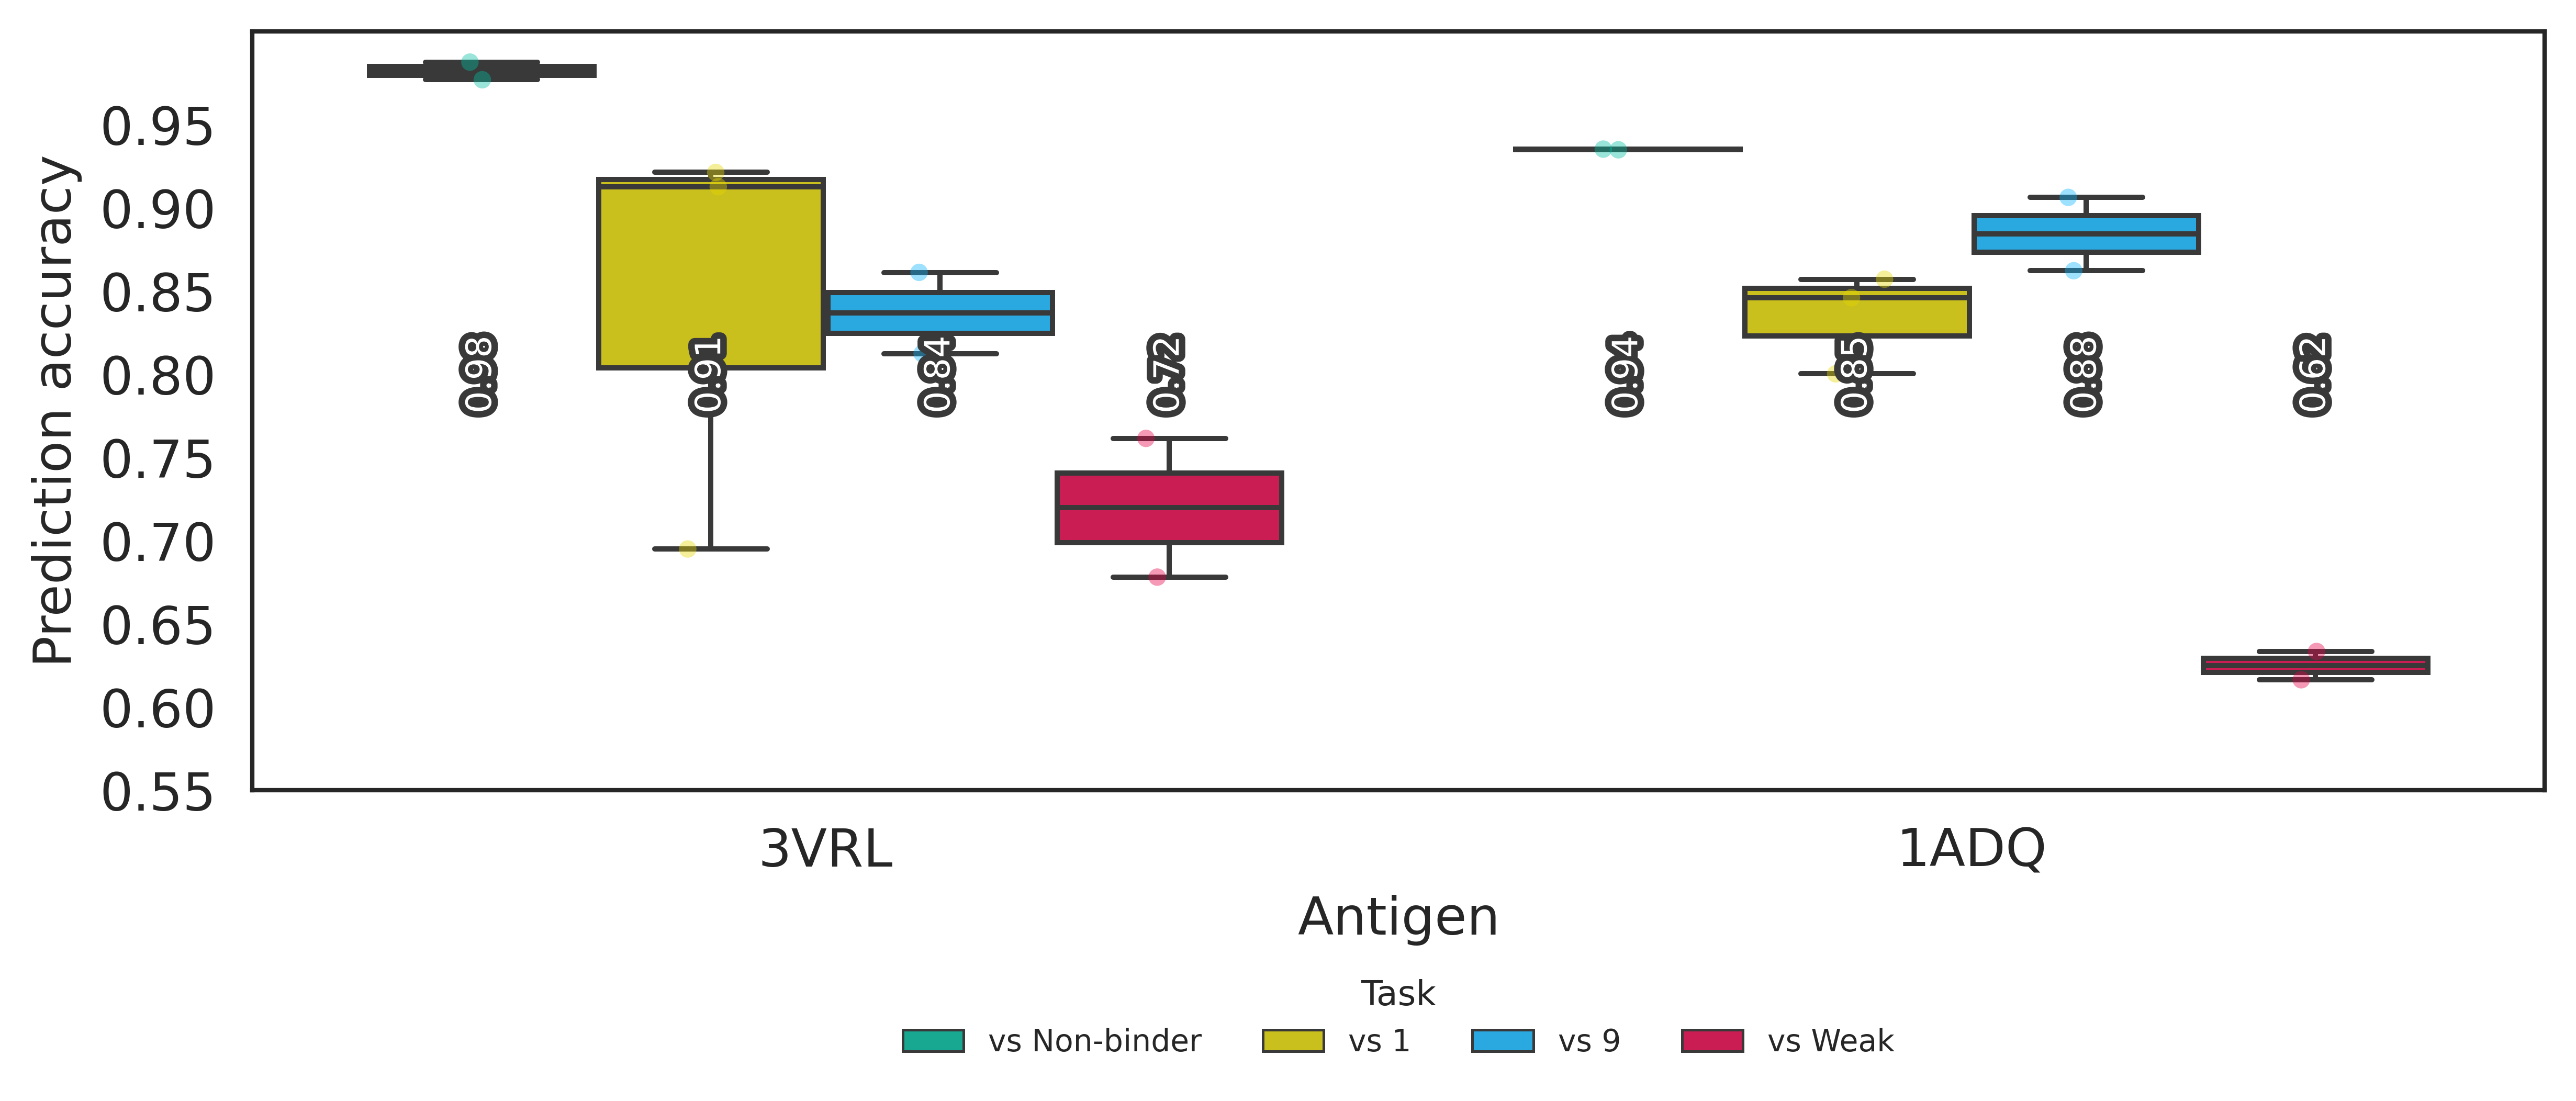

In [8]:
cmap = visualisations.PlotParams.cmap_tasks

sns.set_theme(context="paper")
sns.set_style("white")
fig, ax = plt.subplots(figsize=(3 * 3.14, 3.14), dpi=600)


## Add data points on top of boxplot in low transparency
sns.stripplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    # Order on x axis
    order=ag_order,
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]),
    # palette="Set2",
    palette=cmap,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

sns.boxplot(
    x="ag_pos",
    y="acc_closed",
    hue="task_type_clean",
    data=df,
    ax=ax,
    order=ag_order,
    boxprops=dict(alpha=1),  # a better solution is below
    hue_order=map(lambda x: map_task_type_to_clean[x], ["high_vs_95low", "1v1", "1v9", "high_vs_looser"]),
    palette=cmap,
)
## Based on https://github.com/mwaskom/seaborn/issues/979#issuecomment-235082271
for patch in ax.artists:
    fc = patch.get_facecolor()
    patch.set_facecolor(mpl.colors.to_rgba(fc, 0.1))


visualisations.add_median_labels(ax, y_level=0.8, fontsize=8)


FONT_SIZE = 12
ax.tick_params(labelsize=FONT_SIZE)

ax.set_xlabel("Antigen", fontsize=FONT_SIZE)
ax.set_ylabel(yaxis_title, fontsize=FONT_SIZE)

ax.set_yticks(yticks)
# Add legend under the plot, under x axis label
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

fig.show()

In [9]:
df.groupby("ag_pos")["acc_closed"].agg(["median", "std"]).sort_values("median", ascending=False)

,median,std
ag_pos,,
3VRL,0.8614,0.115594
1ADQ,0.8573,0.119637
3RAJ,0.8445,0.006056


## OOD
Precomputation of openset performances (Table 1C) is done in the notebook 15b.

In [10]:
df_o = pd.read_csv(base_p / "openset_performance.tsv", sep="\t")
df_o["ag"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).ag_pos)
df_o["task_1_type"] = df_o["task_1"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
df_o["task_2_type"] = df_o["task_2"].apply(lambda x: datasets.ClassificationTask.init_from_str(x).task_type.to_str())
def get_replicate_id(task_str):
    task = datasets.ClassificationTask.init_from_str(task_str)
    return str(task.seed_id) + "_" + str(task.split_id)
df_o["replicate_id"] = df_o["task_1"].apply(get_replicate_id)

print(df_o.shape)
df_o.head()

(171, 10)


,task_1,task_2,acc,recall,precision,f1,ag,task_1_type,task_2_type,replicate_id
0,HIGH_VS_95LOW__3VRL__auto__0__1,HIGH_VS_95LOW__3VRL__auto__0__1,0.9880,0.9932,0.982977,0.988062,3VRL,high_vs_95low,high_vs_95low,0_1
1,HIGH_VS_95LOW__3VRL__auto__0__1,HIGH_VS_LOOSER__3VRL__auto__0__1,0.6674,0.9928,0.601405,0.749057,3VRL,high_vs_95low,high_vs_looser,0_1
2,HIGH_VS_95LOW__3VRL__auto__0__1,ONE_VS_NINE__3VRL__auto__0__1,0.8580,0.9934,0.781712,0.874934,3VRL,high_vs_95low,1v9,0_1
3,HIGH_VS_95LOW__3VRL__auto__0__1,HIGH_VS_95LOW__3VRL__auto__0__42,0.9871,0.9944,0.980091,0.987193,3VRL,high_vs_95low,high_vs_95low,0_1
4,HIGH_VS_95LOW__3VRL__auto__0__1,HIGH_VS_LOOSER__3VRL__auto__0__42,0.6556,0.9948,0.592707,0.742832,3VRL,high_vs_95low,high_vs_looser,0_1


In [11]:
df_o_all = df_o.copy()
df_o = df_o.query("task_1_type != '1v1' and task_2_type != '1v1'").copy()

In [12]:
df_o["model_task"] = df_o["task_1_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_o["test_task"] = df_o["task_2_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

In [13]:
df_o

,task_1,task_2,acc,recall,precision,f1,ag,task_1_type,task_2_type,replicate_id,model_task,test_task
0,HIGH_VS_95LOW__3VRL__auto__0__1,HIGH_VS_95LOW__3VRL__auto__0__1,0.9880,0.9932,0.982977,0.988062,3VRL,high_vs_95low,high_vs_95low,0_1,vs Non-binder,vs Non-binder
1,HIGH_VS_95LOW__3VRL__auto__0__1,HIGH_VS_LOOSER__3VRL__auto__0__1,0.6674,0.9928,0.601405,0.749057,3VRL,high_vs_95low,high_vs_looser,0_1,vs Non-binder,vs Weak
2,HIGH_VS_95LOW__3VRL__auto__0__1,ONE_VS_NINE__3VRL__auto__0__1,0.8580,0.9934,0.781712,0.874934,3VRL,high_vs_95low,1v9,0_1,vs Non-binder,vs 9
3,HIGH_VS_95LOW__3VRL__auto__0__1,HIGH_VS_95LOW__3VRL__auto__0__42,0.9871,0.9944,0.980091,0.987193,3VRL,high_vs_95low,high_vs_95low,0_1,vs Non-binder,vs Non-binder
4,HIGH_VS_95LOW__3VRL__auto__0__1,HIGH_VS_LOOSER__3VRL__auto__0__42,0.6556,0.9948,0.592707,0.742832,3VRL,high_vs_95low,high_vs_looser,0_1,vs Non-binder,vs Weak
...,...,...,...,...,...,...,...,...,...,...,...,...
127,ONE_VS_NINE__1ADQ__auto__0__42,HIGH_VS_LOOSER__1ADQ__auto__0__1,0.5405,0.8254,0.525799,0.642385,1ADQ,1v9,high_vs_looser,0_42,vs 9,vs Weak
128,ONE_VS_NINE__1ADQ__auto__0__42,ONE_VS_NINE__1ADQ__auto__0__1,0.8683,0.7666,0.962340,0.853390,1ADQ,1v9,1v9,0_42,vs 9,vs 9
129,ONE_VS_NINE__1ADQ__auto__0__42,HIGH_VS_95LOW__1ADQ__auto__0__42,0.5151,0.9258,0.508290,0.656270,1ADQ,1v9,high_vs_95low,0_42,vs 9,vs Non-binder
130,ONE_VS_NINE__1ADQ__auto__0__42,HIGH_VS_LOOSER__1ADQ__auto__0__42,0.5422,0.8308,0.526756,0.644731,1ADQ,1v9,high_vs_looser,0_42,vs 9,vs Weak


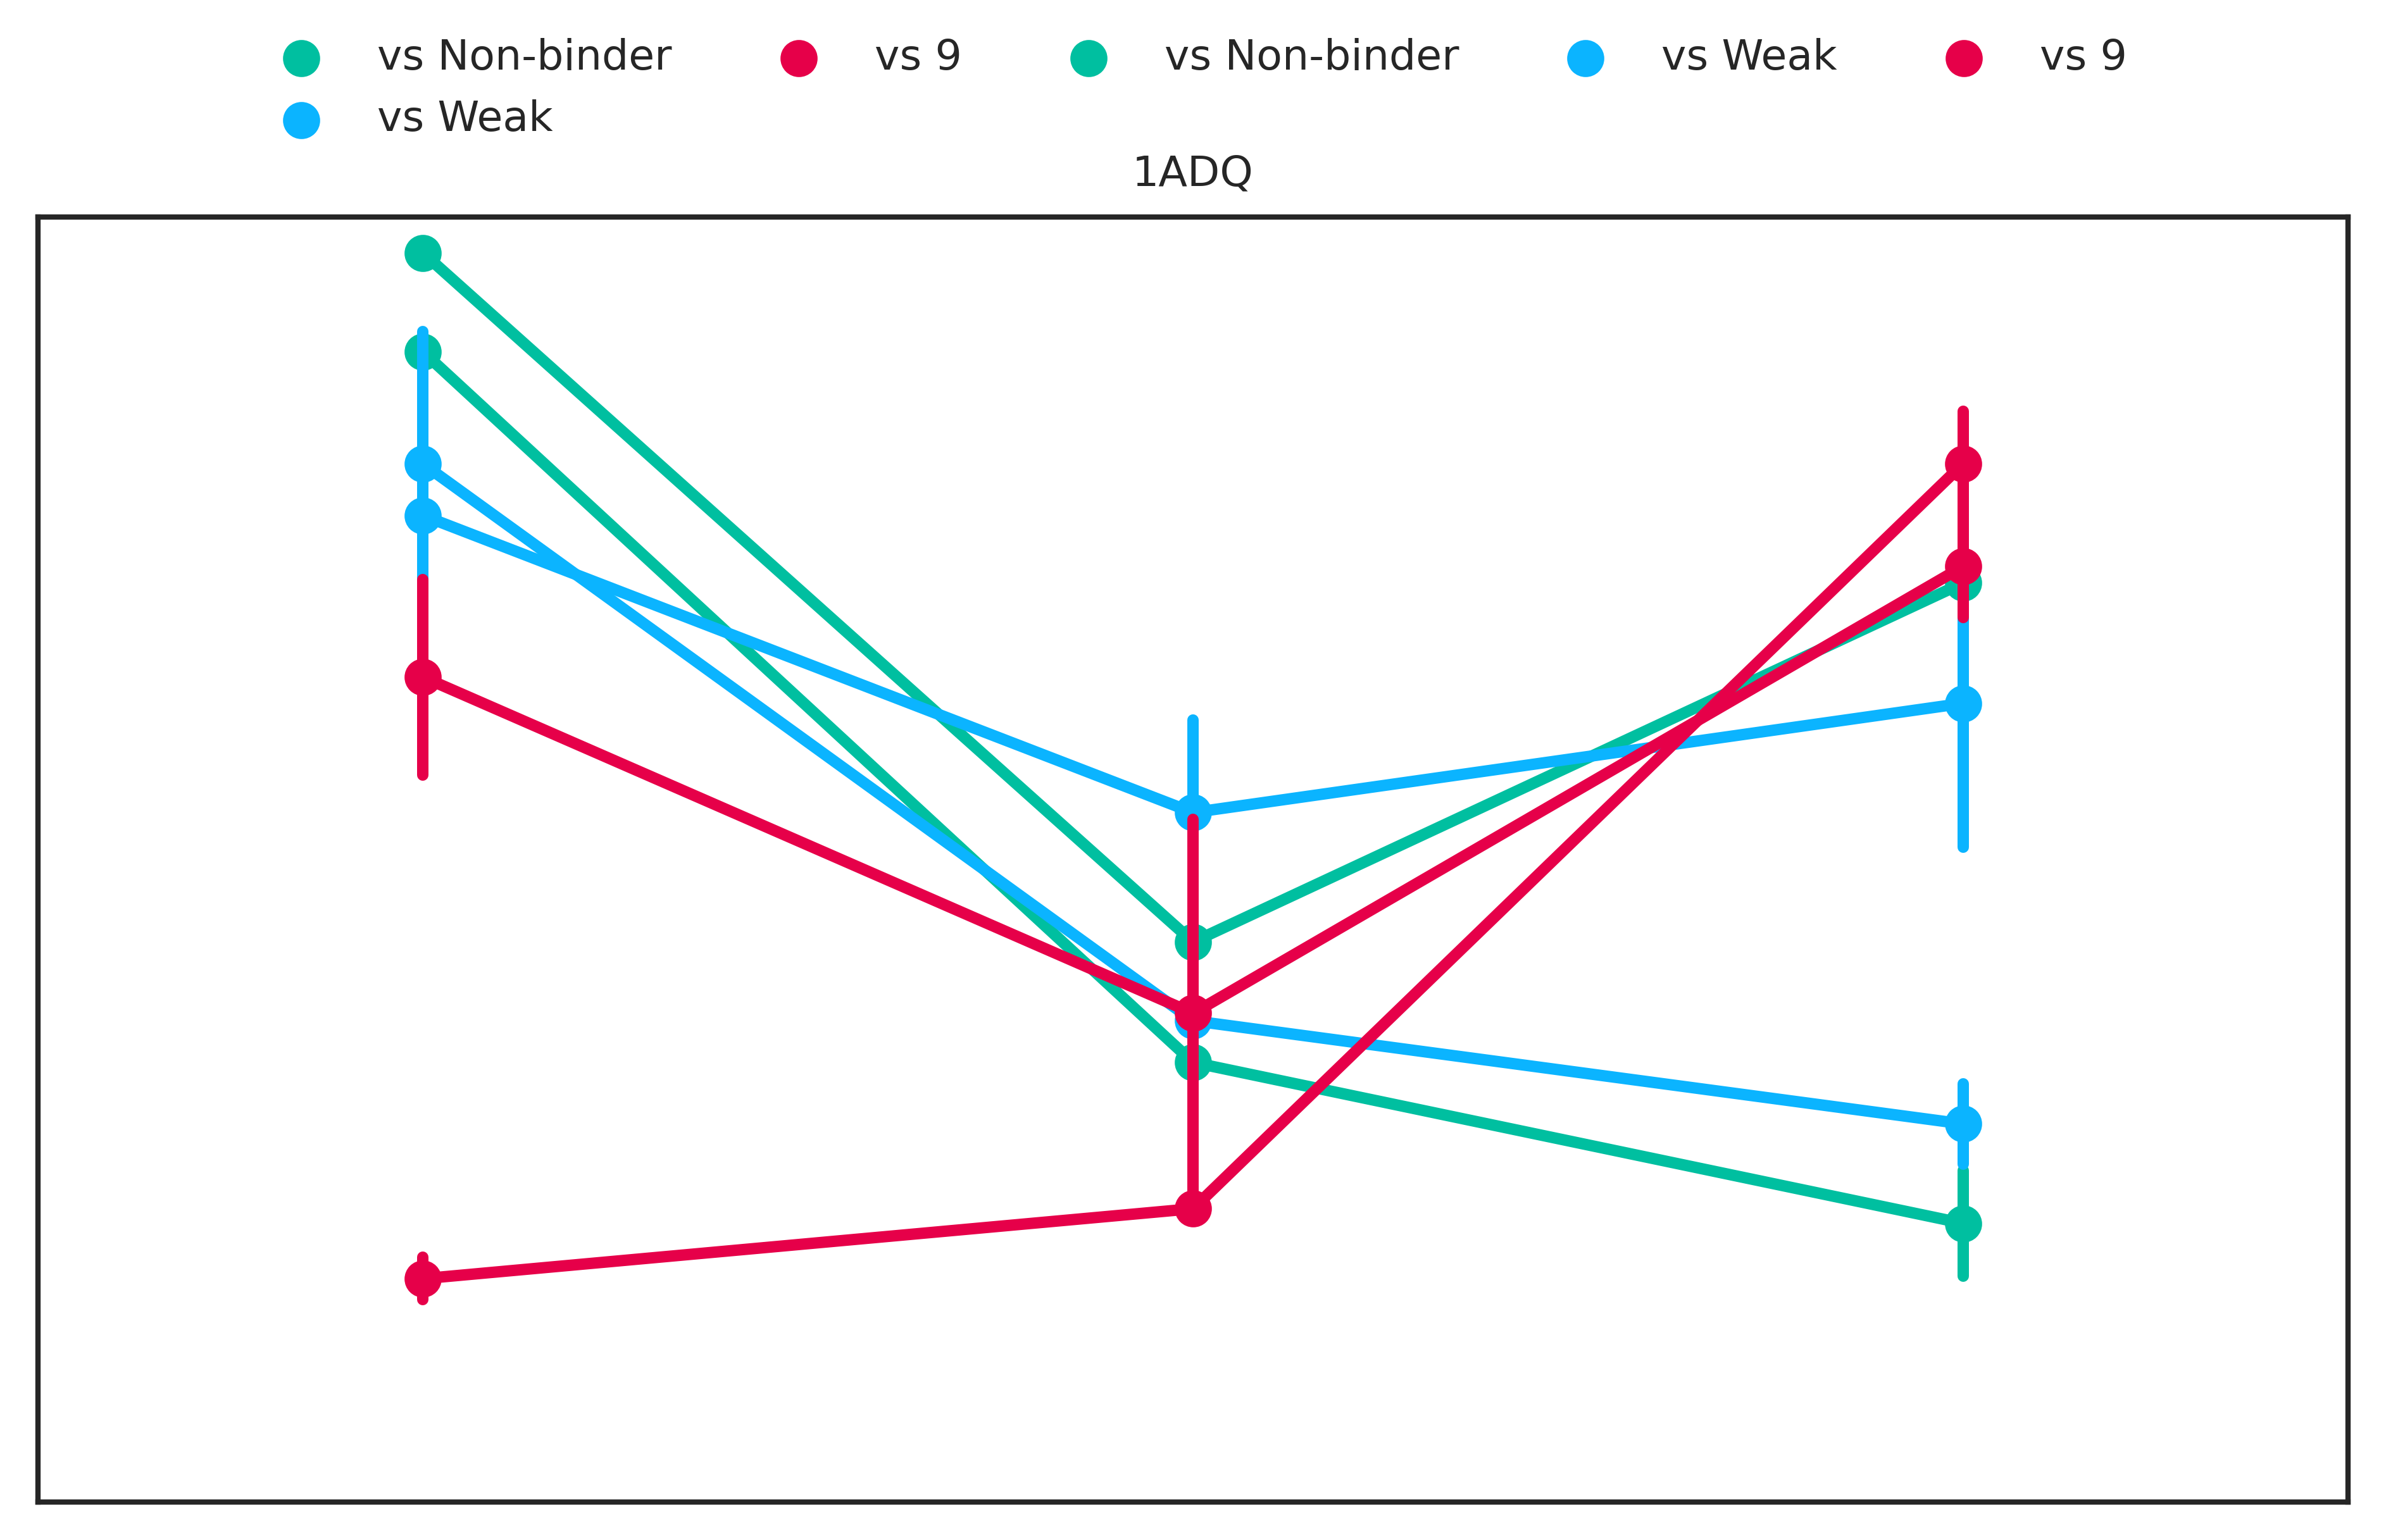

In [14]:
cmap = [
    # Selection from Dutch Field
    "#00bfa0",  # Dark Green
    "#0bb4ff",  # Blue
    "#e60049",  # Red
]
fig, ax = plt.subplots(figsize=(2.5 * 3.14, 1.4 * 3.14), dpi=600)

order_tasks_nonclean = ["high_vs_95low", "high_vs_looser", "1v9"]
task_order = list(map(lambda x: map_task_type_to_clean[x], order_tasks_nonclean))

order_antigens = ["3VRL", "1ADQ"]

for i, ag in enumerate(order_antigens):
    row = 0
    col = i
    df_i = df_o.query("ag == @ag")
    sns.pointplot(
        df_i,
        x="test_task",
        y="acc",
        order=task_order,
        hue="model_task",
        hue_order=task_order,
        errorbar="sd",
        # palette=visualisations.PlotParams.cmap_tasks_no1v1,
        palette=cmap,
        ax=ax,
    )

    ax.legend().remove()

    ax.set_xlabel(None)
    if row == 0:
        ax.set_xticks([])
    elif row == 1:
        for tick in ax.get_xticklabels():
            # tick.set_rotation(45)
            # 45 degree rotation, but with the text centered
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    ax.set_ylim(0.4, 1.0)
    ax.set_yticks([0.6, 0.7, 0.8, 0.9, 1.0])
    if col == 0:
        ax.set_ylabel("Prediction accuracy", fontsize=8)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel(None)

    ax.set_title(f"{ag}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8)

    # Tables inside the plot
    if row == 1 and col in [1, 2]:
        loc = "lower center"
    else:
        loc = "lower left"
    table_values = (
        df_i.groupby(["model_task", "test_task"])["acc"]
        .mean()
        .reset_index()
        .pivot(index="model_task", columns="test_task", values="acc")
        .loc[task_order][task_order]
        .values * 100).round().astype(int)
    table_values = np.where(table_values == 100, "", table_values)
    # ax.table(
    #     cellText=table_values,
    #     loc=loc,
    #     colWidths=[0.1, 0.1, 0.1],
    #     cellColours=np.array([cmap for _ in range(3)]).transpose(),
    # )

# Add one legend horizontal above all subplots, as part of figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)

# Add text horizontal under all subplots, as part of figure
# fig.text(0.5, 0.001, "Tested on", ha="center", fontsize=8);

# fig.savefig("figures/1D1.svg")
fig.show()

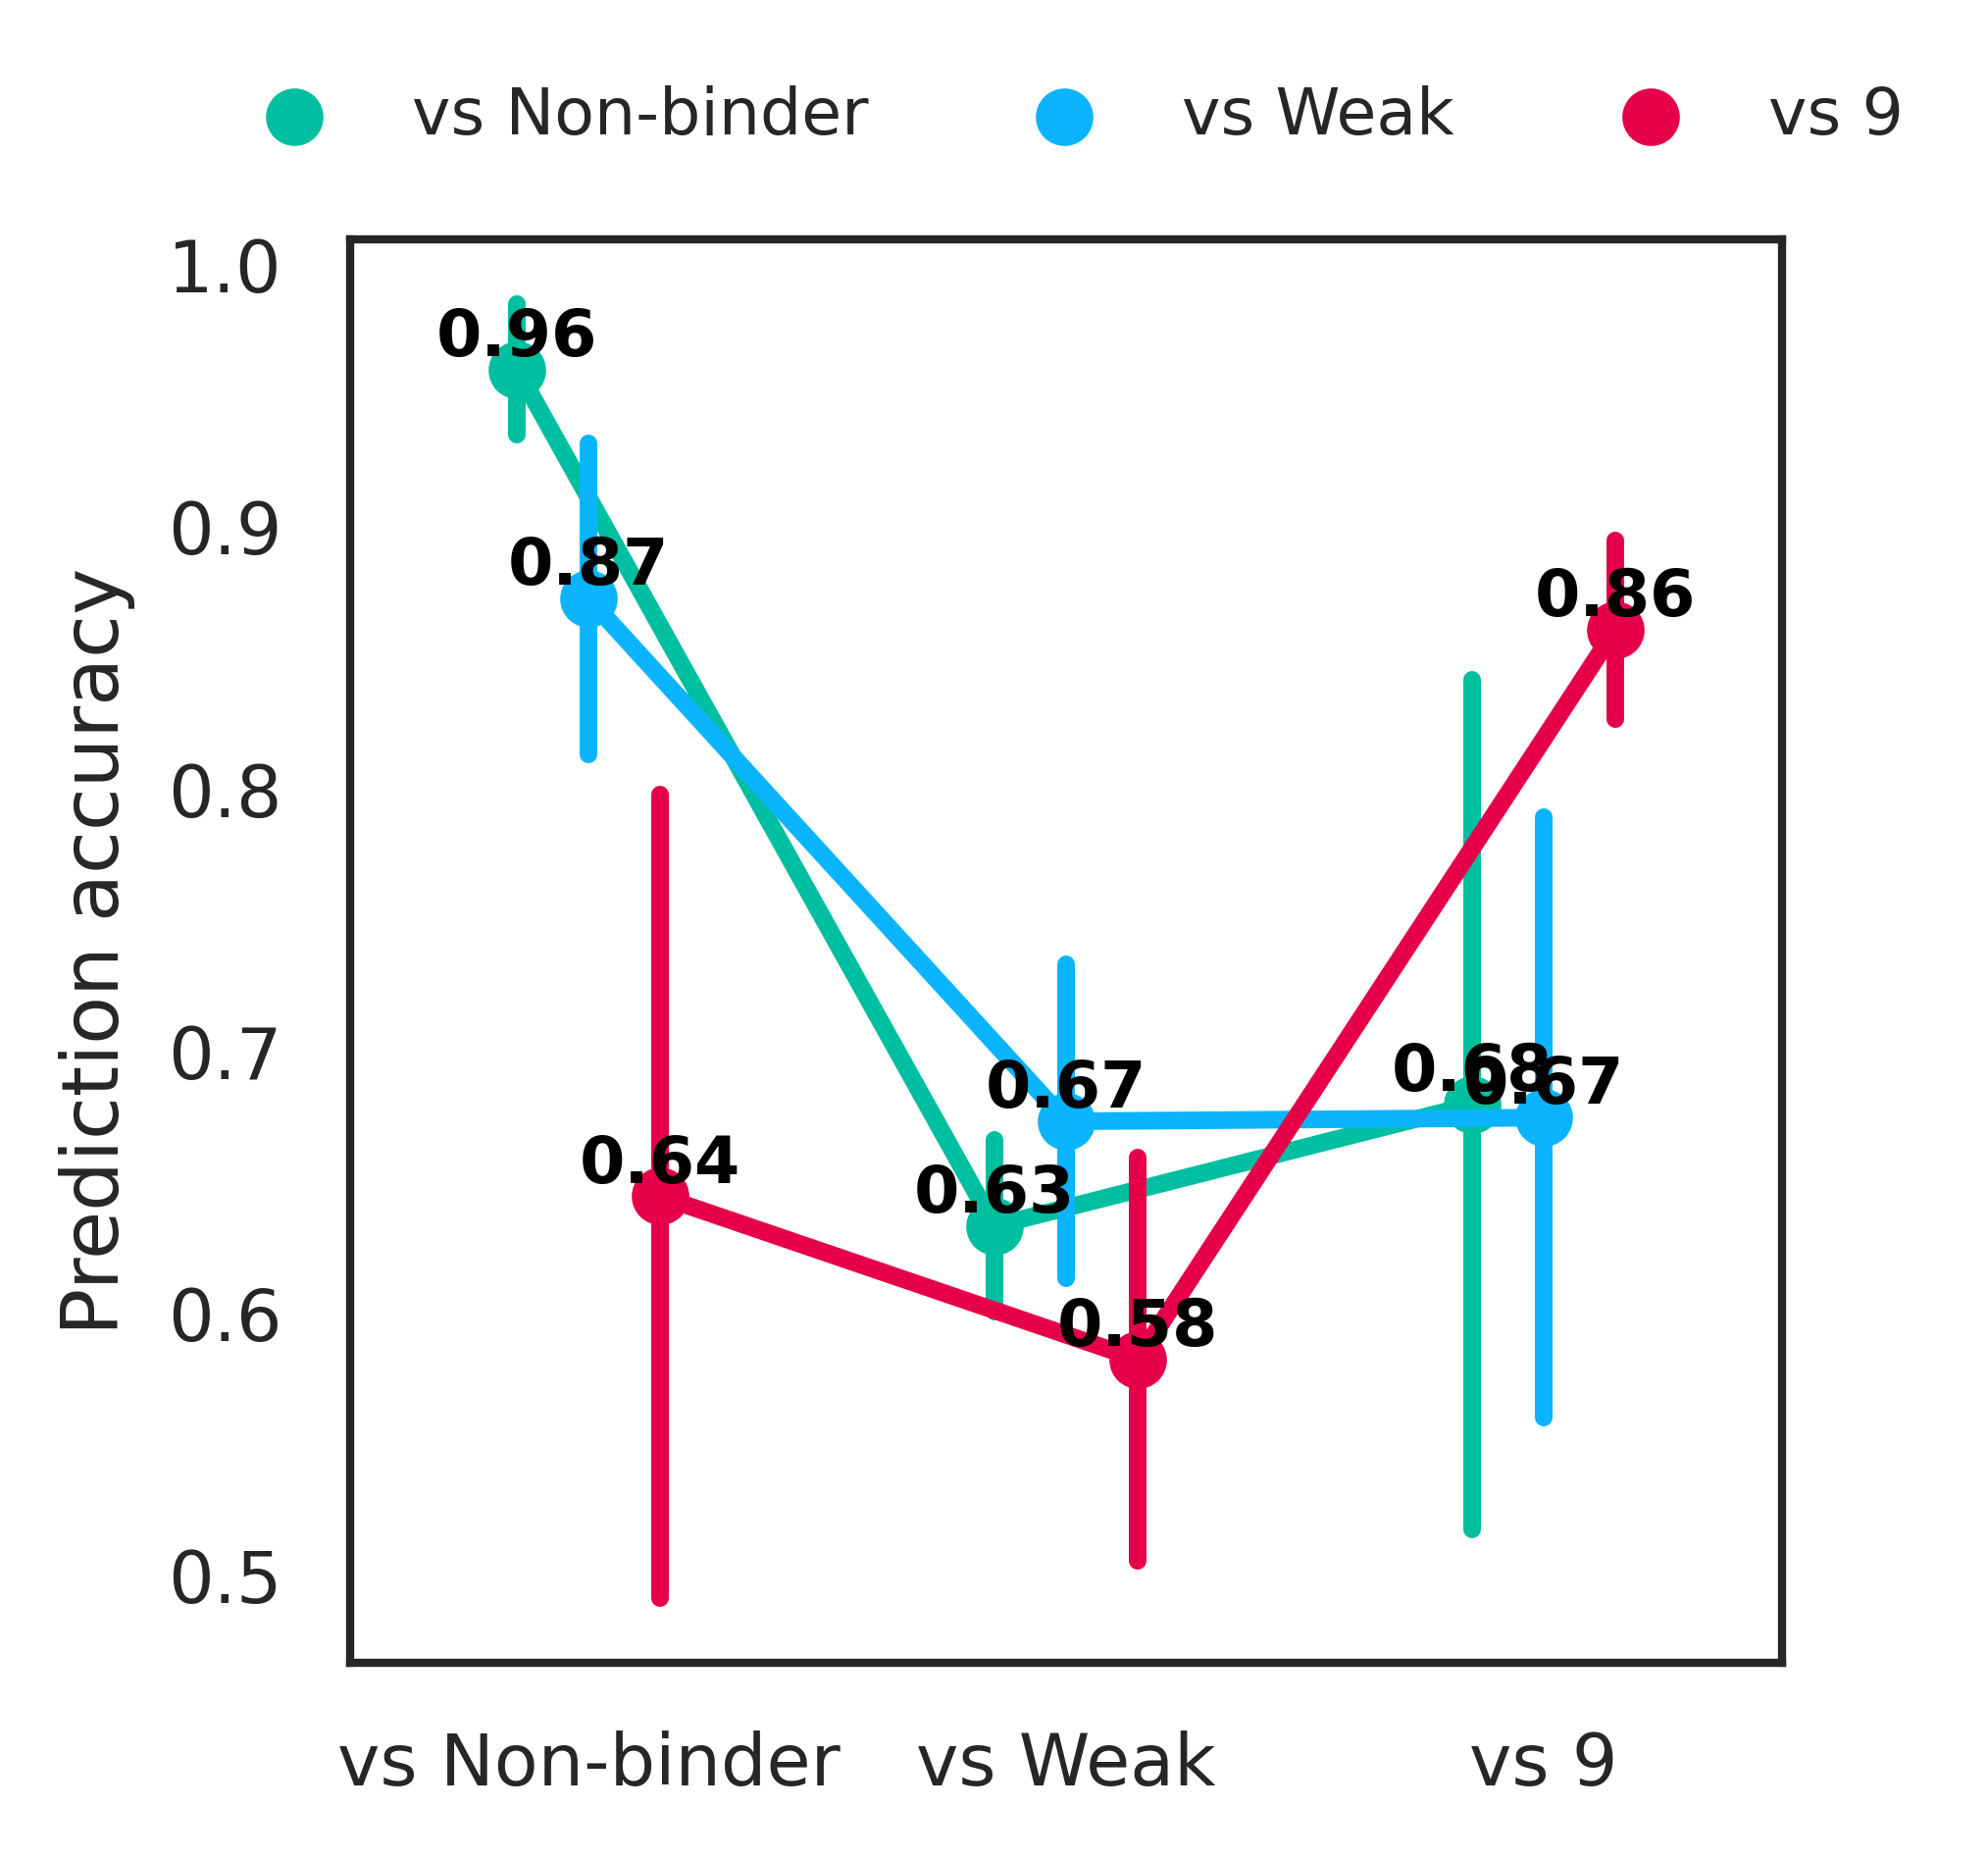

In [15]:
fig, ax = plt.subplots(figsize=(1*3.14, 1* 3.14), dpi=600)
sns.pointplot(
    df_o,
    y="acc",
    x="test_task",
    errorbar="sd",
    order=task_order,
    hue="model_task",
    hue_order=task_order,
    palette=cmap,
    # Spread out the points a bit in horizontal
    dodge=0.3,
    ax=ax,
)

# Add legend horizontally on top of plot area, outside plot area
ax.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, 1.15),
    ncol=3,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    # title_fontsize=8,
)

ax.set_xlabel(None)
ax.set_ylabel("Prediction accuracy")

# Add text
for i, col in enumerate(ax.collections):
    for j, txt in enumerate(col.get_offsets()[:, 0]):
        ax.text(
            txt,
            col.get_offsets()[j, 1],
            f"{col.get_offsets()[j, 1]:.2f}",
            ha="center",
            va="bottom",
            color="black",
            fontsize=8,
            fontweight="bold",
        )

fig.show()

Check for results for the randomized sequences in HR2P

In [16]:
# Drop HR2B
df_o_all = df_o_all.query("ag != 'HR2B'").copy()

for _, row in df_o_all.iterrows():
    
    if row["task_1"].split("__")[-3] == "HR2PSR":
        task_1_type = "high_vs_randseq"
    elif row["task_1"].split("__")[-3] == "HR2PIR":
        task_1_type = "high_vs_randpos"
    else:
        task_1_type = row["task_1_type"]
    df_o_all.loc[_, "task_1_type"] = task_1_type

    # Same for task_2
    if row["task_2"].split("__")[-3] == "HR2PSR":
        task_2_type = "high_vs_randseq"
    elif row["task_2"].split("__")[-3] == "HR2PIR":
        task_2_type = "high_vs_randpos"
    else:
        task_2_type = row["task_2_type"]
    df_o_all.loc[_, "task_2_type"] = task_2_type

df_o_all["model_task"] = df_o_all["task_1_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])
df_o_all["test_task"] = df_o_all["task_2_type"].apply(lambda x: visualisations.PlotParams.map_task_type_to_clean[x])

KeyError: "None of [Index(['vs Non-binder', 'vs Weak', 'vs Randomized'], dtype='object', name='model_task')] are in the [index]"

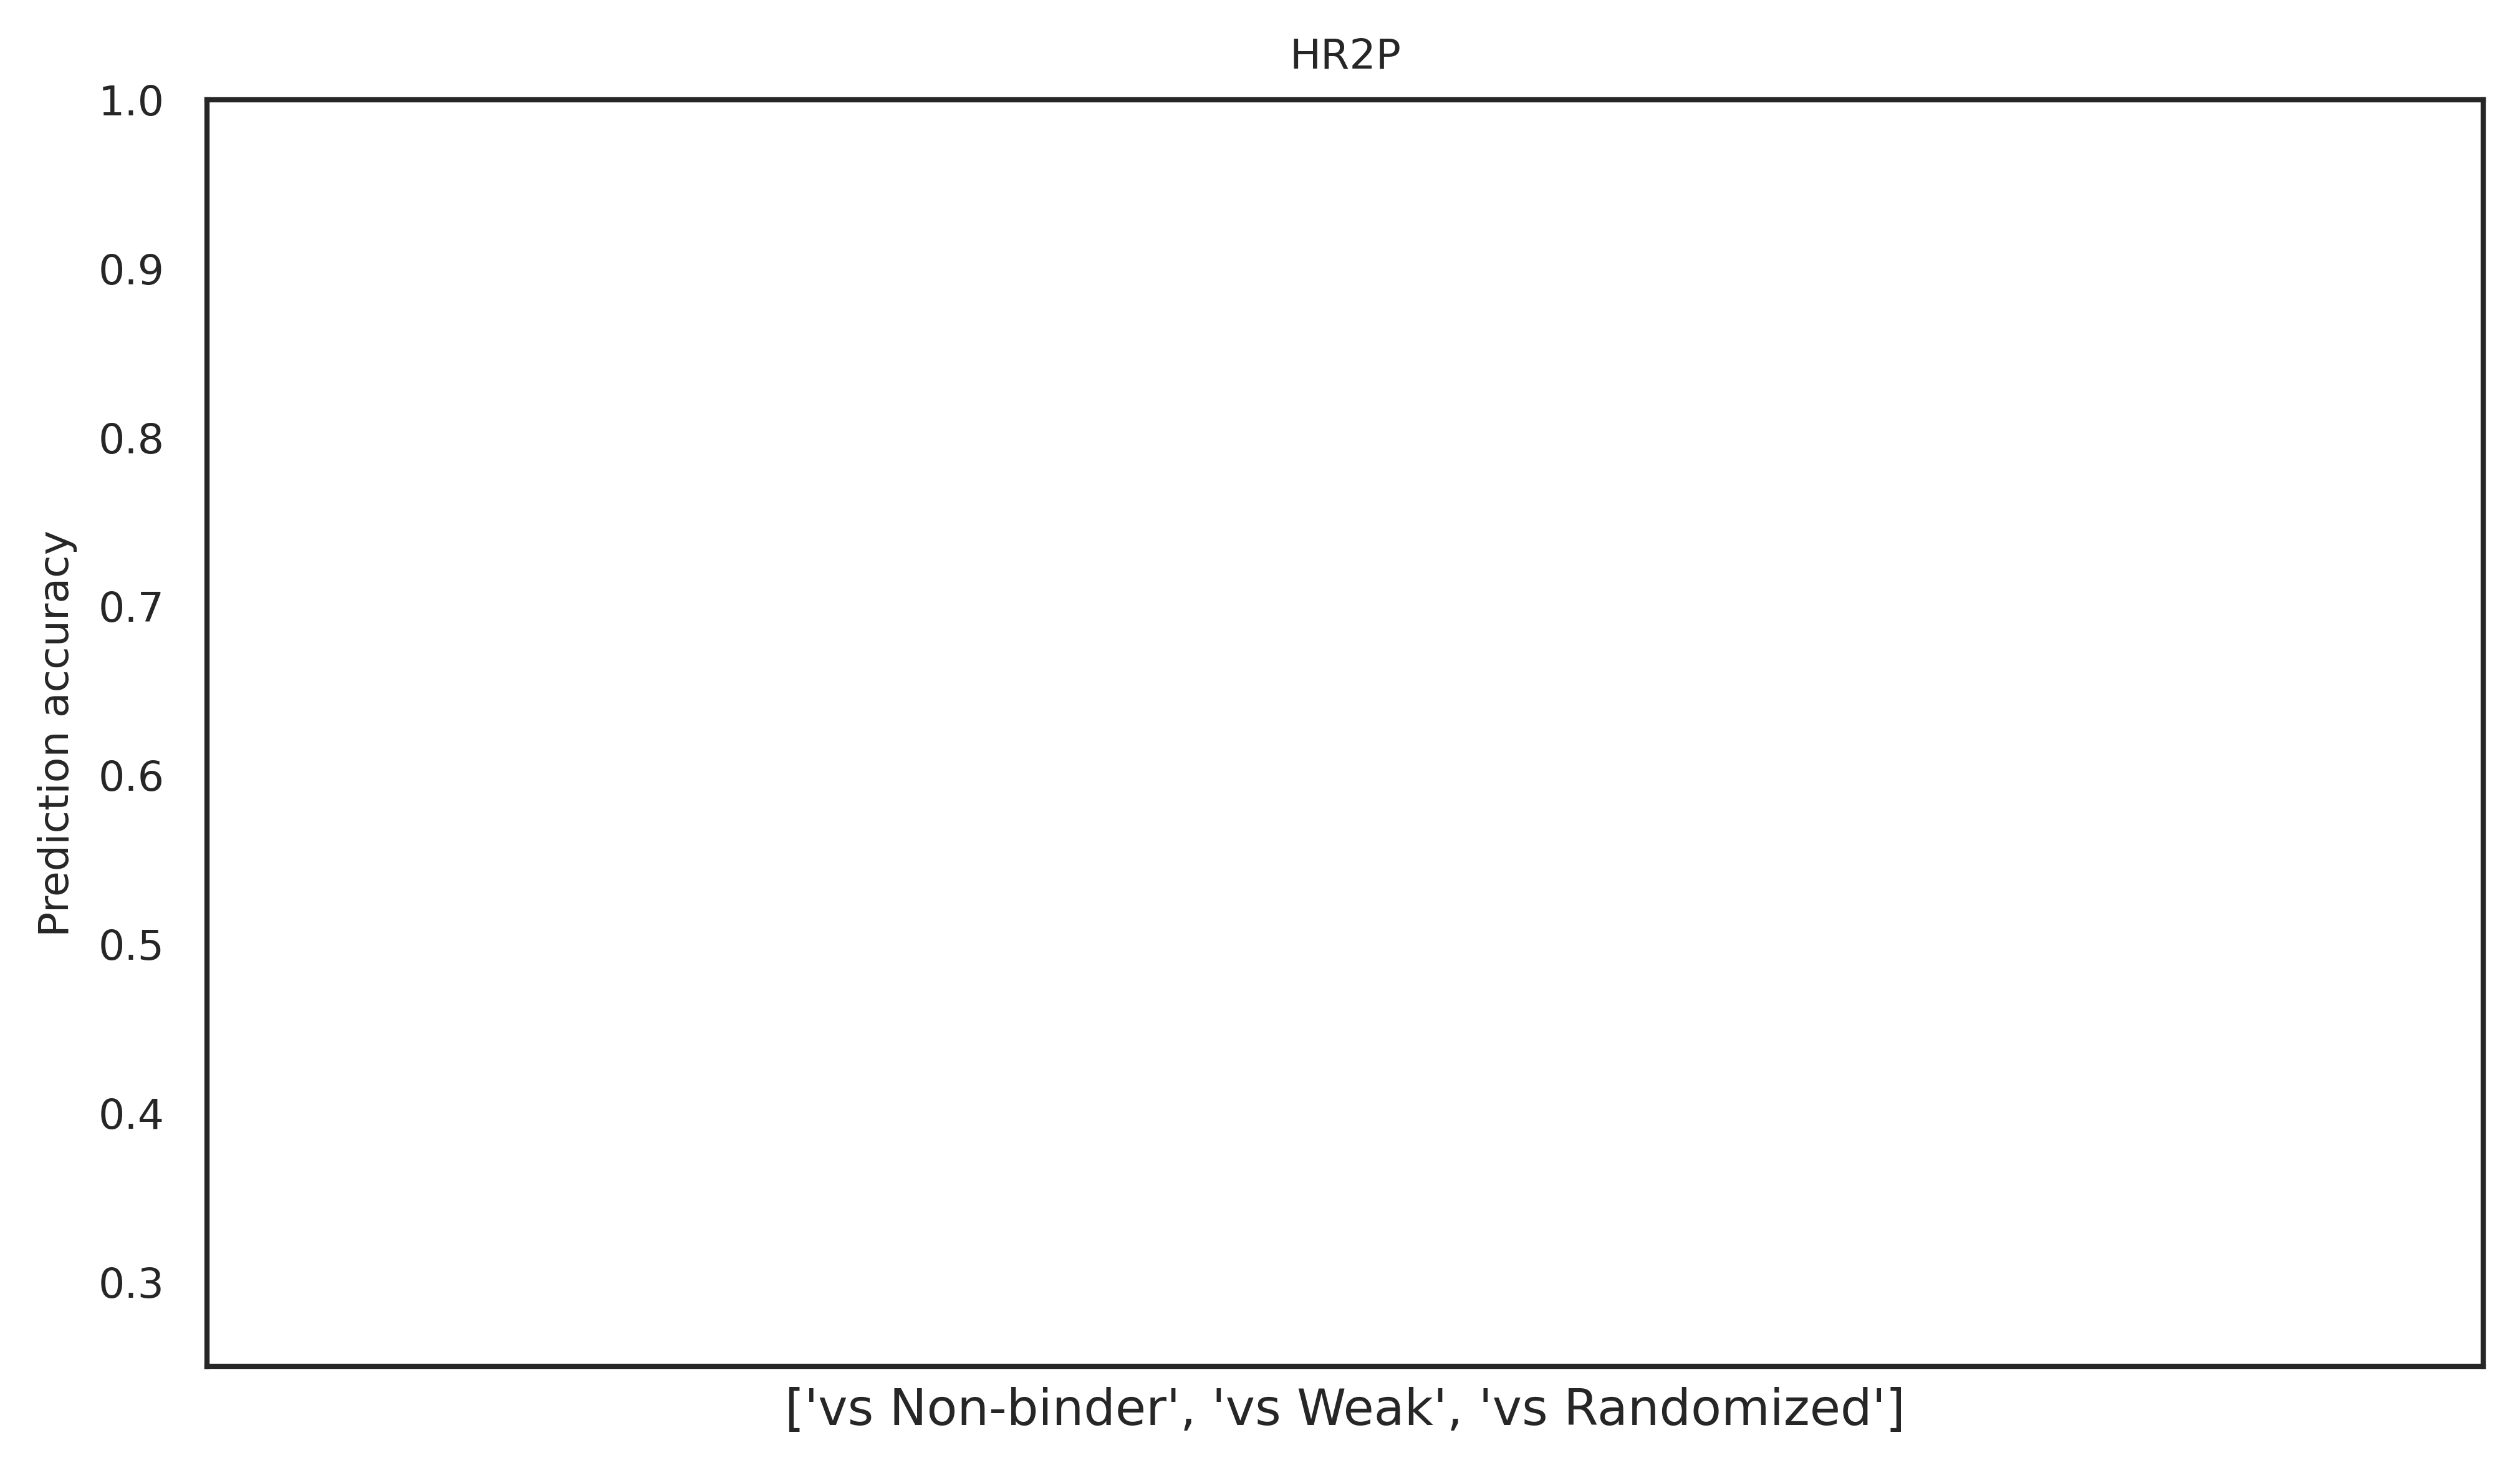

In [17]:
cmap = [
    # Selection from Dutch Field
    "#0bb4ff",  # Blue
    "#f5b700",  # Yellow
    "#00bfa0",  # Dark Green
    # "#e60049",  # Red
]
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(2.5 * 3.14, 1.4 * 3.14), dpi=600)

# order_tasks_nonclean = ["high_vs_95low", "high_vs_looser", "high_vs_randseq", "high_vs_randpos"]
order_tasks_nonclean = ["high_vs_95low", "high_vs_looser", "high_vs_randseq"]
task_order = list(map(lambda x: map_task_type_to_clean[x], order_tasks_nonclean))

order_antigens = ["HR2P"]

for i, ag in enumerate(order_antigens):
    row = 0
    col = i
    ax = axs
    df_i = df_o_all.query("ag == @ag")
    sns.pointplot(
        df_i,
        x="test_task",
        y="acc",
        order=task_order,
        hue="model_task",
        hue_order=task_order,
        errorbar="sd",
        # palette=visualisations.PlotParams.cmap_tasks_no1v1,
        palette=cmap,
        ax=ax,
    )

    ax.legend().remove()

    ax.set_xlabel(None)
    if row == 0:
        ax.set_xticks([])
    elif row == 1:
        for tick in ax.get_xticklabels():
            # tick.set_rotation(45)
            # 45 degree rotation, but with the text centered
            tick.set_rotation(45)
            tick.set_horizontalalignment("right")

    ax.set_ylim(0.25, 1.0)
    ax.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    if col == 0:
        ax.set_ylabel("Prediction accuracy", fontsize=8)
    else:
        ax.set_yticklabels([])
        ax.set_ylabel(None)

    ax.set_xlabel(task_order)
    ax.set_title(f"{ag}", fontsize=8)
    ax.tick_params(axis="both", which="major", labelsize=8)

# Add table
loc = "lower right"
table_values = (
    df_i.groupby(["model_task", "test_task"])["acc"]
    .median()
    .reset_index()
    .pivot(index="model_task", columns="test_task", values="acc")
    .loc[task_order][task_order]
    .values * 100).round().astype(int)
# table_values = np.where(table_values == 100, "", table_values)
ax.table(
    cellText=table_values,
    loc=loc,
    cellLoc="center",
    colWidths=[0.08, 0.08, 0.08],
    cellColours=np.array([cmap for _ in range(3)]).transpose(),
)

# Add one legend horizontal above all subplots, as part of figure
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=5,
    fontsize=8,
    frameon=False,
    # title="Model trained on",
    title_fontsize=8,
)

fig.show()